In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.special as sp
from math import factorial
import pymc as pm
import pymc.sampling_jax
from scipy.integrate import quad
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

In [3]:
n = 100
lam_true = 2
y = rng.poisson(lam=lam_true, size=n)
print(y)

[4 3 3 2 1 5 2 0 1 3 1 0 1 4 3 1 1 4 1 0 4 2 0 1 2 0 1 4 2 0 2 1 2 2 0 0 5
 2 0 2 2 4 2 1 2 0 1 3 0 3 3 1 2 0 2 1 2 2 2 4 3 2 6 3 0 3 0 1 1 2 3 0 1 1
 3 3 0 2 3 1 2 1 6 0 3 3 2 2 3 0 1 2 2 1 0 0 1 3 3 1]


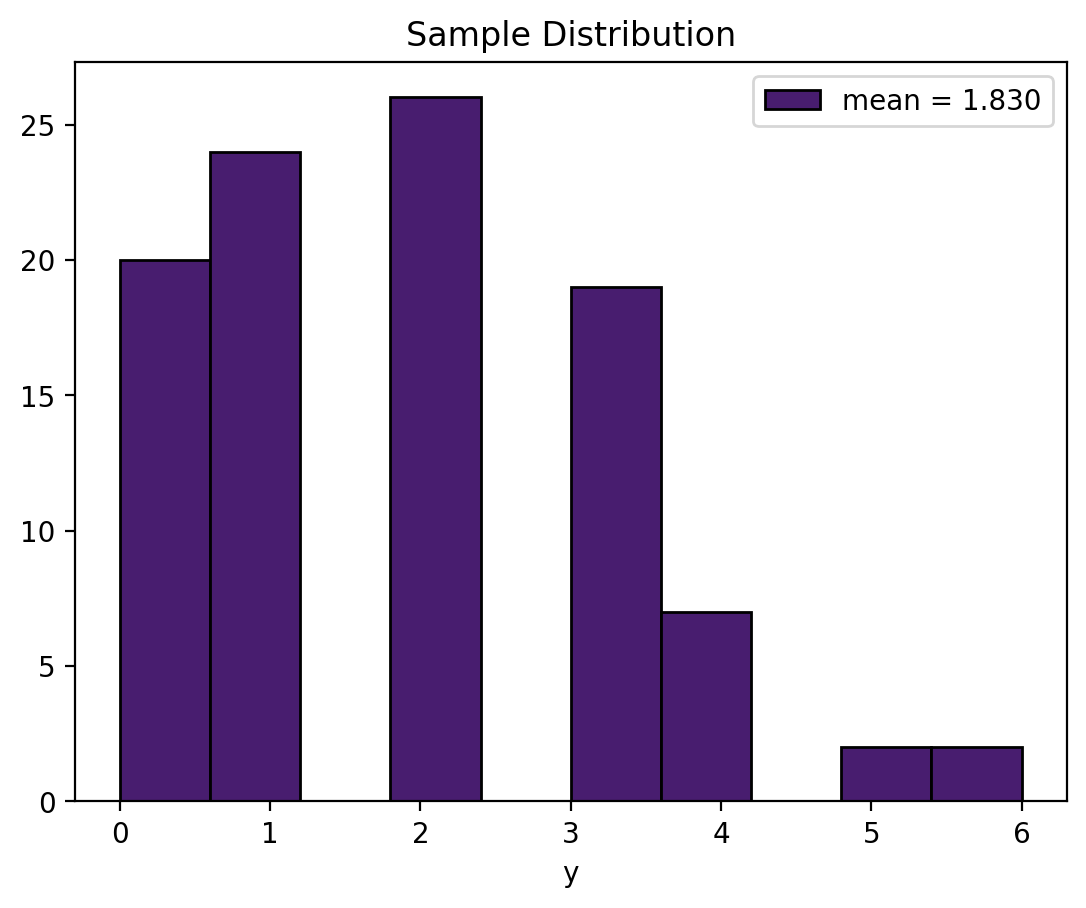

In [4]:
plt.hist(y, edgecolor="black", bins=10)  # You can change the number of bins if desired
mean_y = y.mean()
plt.legend([f"mean = {mean_y:0.3f}"], loc="upper right")
plt.title("Sample Distribution")
plt.xlabel("y")
plt.show()

In [5]:
a = 3  # shape
b = 1  # rate = 1/scale

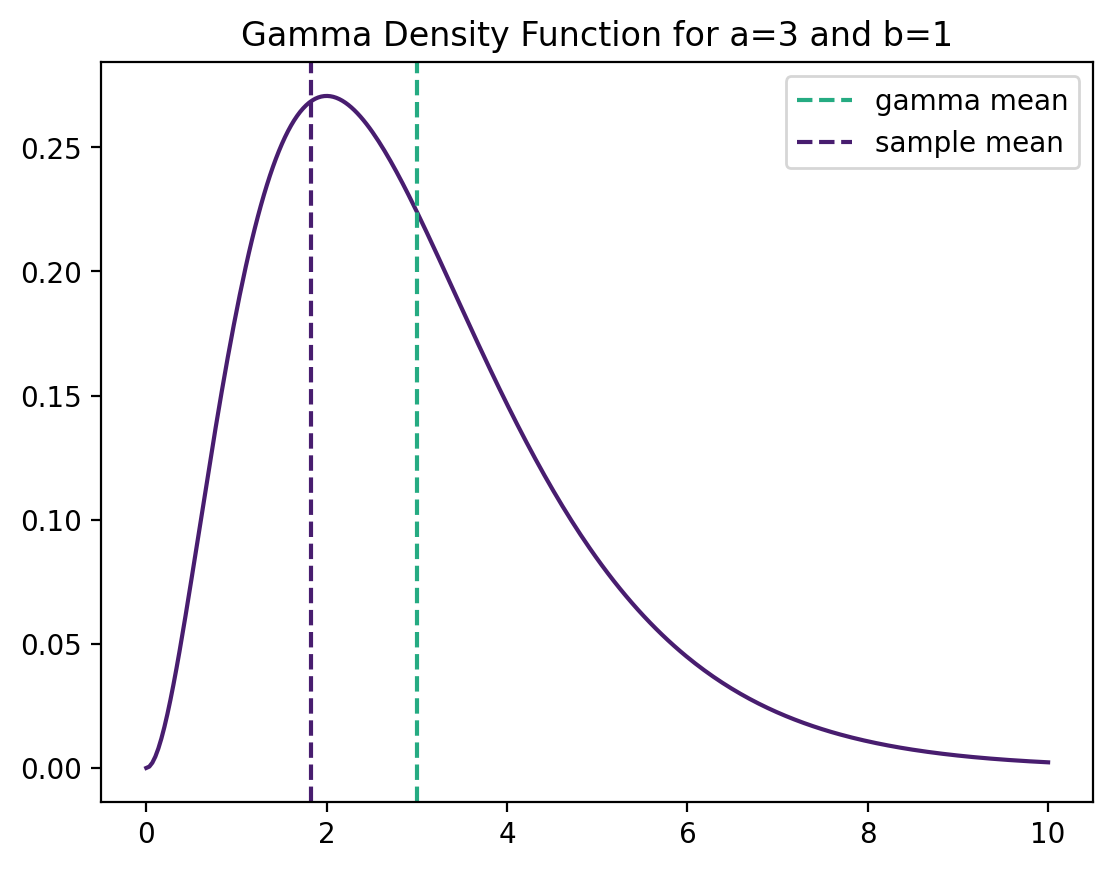

In [6]:
x = np.linspace(start=0, stop=10, num=300)

plt.plot(x, stats.gamma.pdf(x, a=a, scale=1 / b))
plt.axvline(x=a / b, linestyle="--", color="C2", label="gamma mean")
plt.axvline(x=y.mean(), linestyle="--", label="sample mean")
plt.legend()
plt.title(f"Gamma Density Function for a={a} and b={b}")
plt.show()

In [7]:
def prior(lam):
    return stats.gamma.pdf(lam, a=a, scale=1/b)

In [8]:
def log_likelihood(lam, y):
    log_factorials = [np.log(factorial(i)) for i in y]
    log_numerator = (-lam * y.size) + (y.sum() * np.log(lam))
    log_denominator = np.sum(log_factorials)
    return np.exp(log_numerator - log_denominator)

In [9]:
# Define the posterior distribution (up to a constant)
def posterior_up_to_constant(lam, y):
    return log_likelihood(lam=lam, y=y) * prior(lam)

In [10]:
lower_bound = 0
upper_bound = 10

def integrand(lam, y):
    return posterior_up_to_constant(lam, y)

normalizing_constant, _ = quad(integrand, lower_bound, upper_bound, args=(y,))

In [11]:
def posterior(lam, y):
    return posterior_up_to_constant(lam, y) / normalizing_constant

In [12]:
x = np.linspace(start=0, stop=10, num=300)

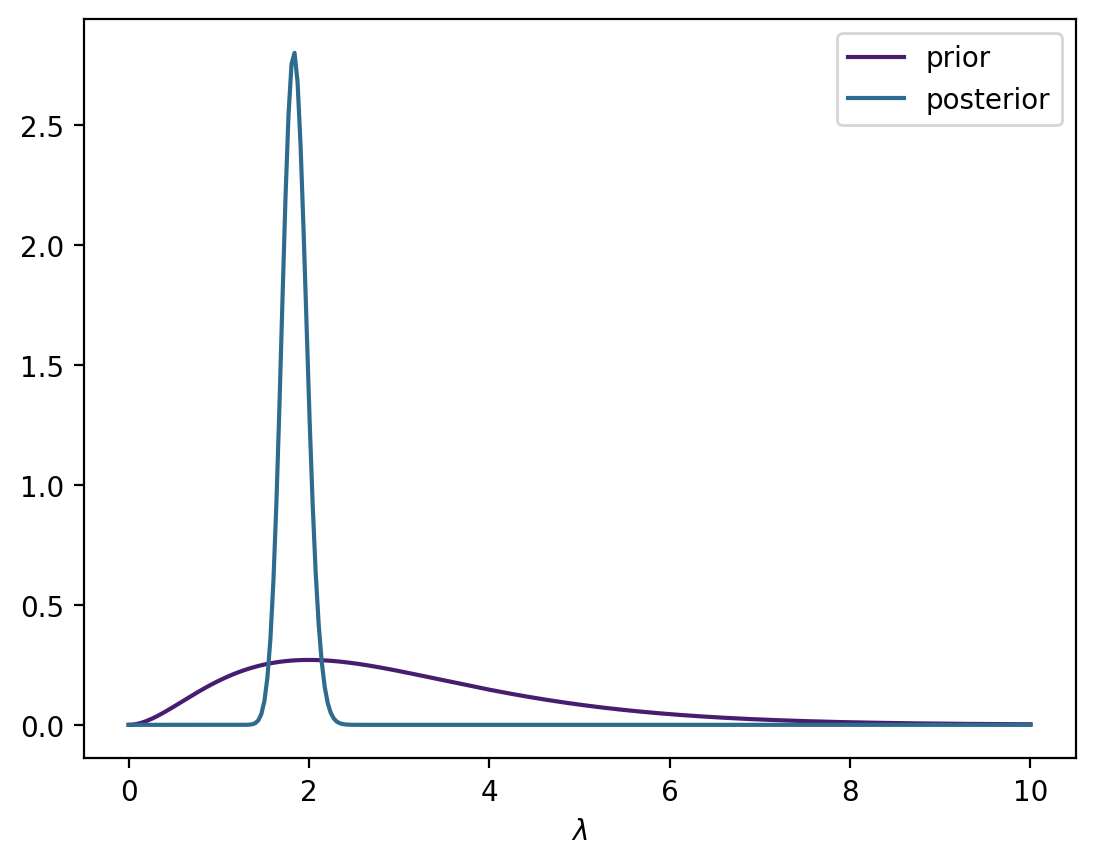

In [13]:
plt.plot(x, prior(x), label="prior")
plt.plot(x, posterior(x, y), label="posterior")
plt.legend()
plt.xlabel("$\lambda$")
plt.show()

In [14]:
def posterior_an(lam, y):
    shape = a + y.sum()
    rate = b + y.size
    return stats.gamma.pdf(lam, shape, scale=1 / rate)

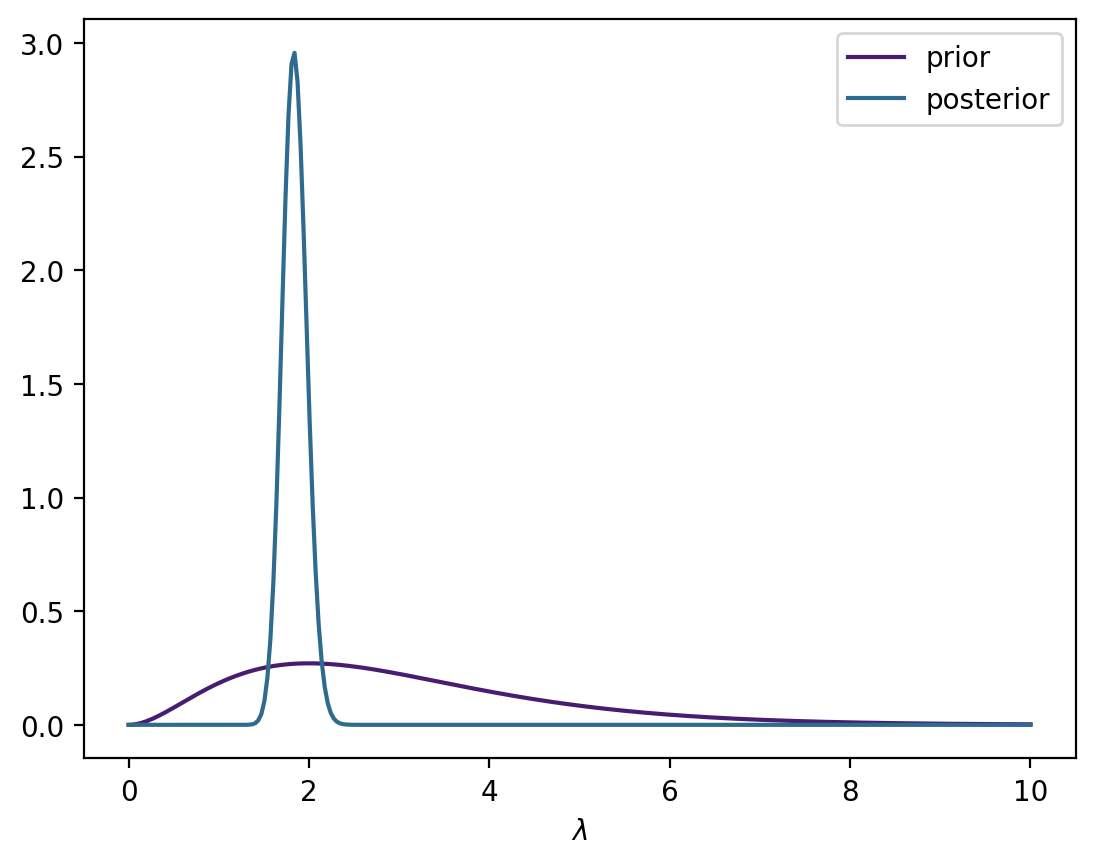

In [15]:
plt.plot(x, prior(x), label="prior")
plt.plot(x, posterior_an(x, y), label="posterior")
plt.legend()
plt.xlabel("$\lambda$")
plt.show()

In [16]:
# Posterior gamma parameters.
shape = a + y.sum()
rate = b + y.size

# Posterior mean.
print(f"Posterior Mean = {shape / rate: 0.3f}")

Posterior Mean =  1.842


In [17]:
df = pd.DataFrame()
df["y"] = y

In [18]:
with pm.Model() as model:
    data = pm.ConstantData("data", df["y"])
    # Define the prior of the parameter lambda.
    lam = pm.Gamma("lambda", alpha=a, beta=b)
    # Define the likelihood function.
    pm.Poisson("y", mu=lam, observed=data)

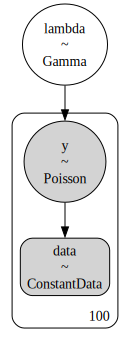

In [19]:
pm.model_to_graphviz(model)

In [20]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time =  0:00:03.396905
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.440766
Transforming variables...
Transformation time =  0:00:00.013994


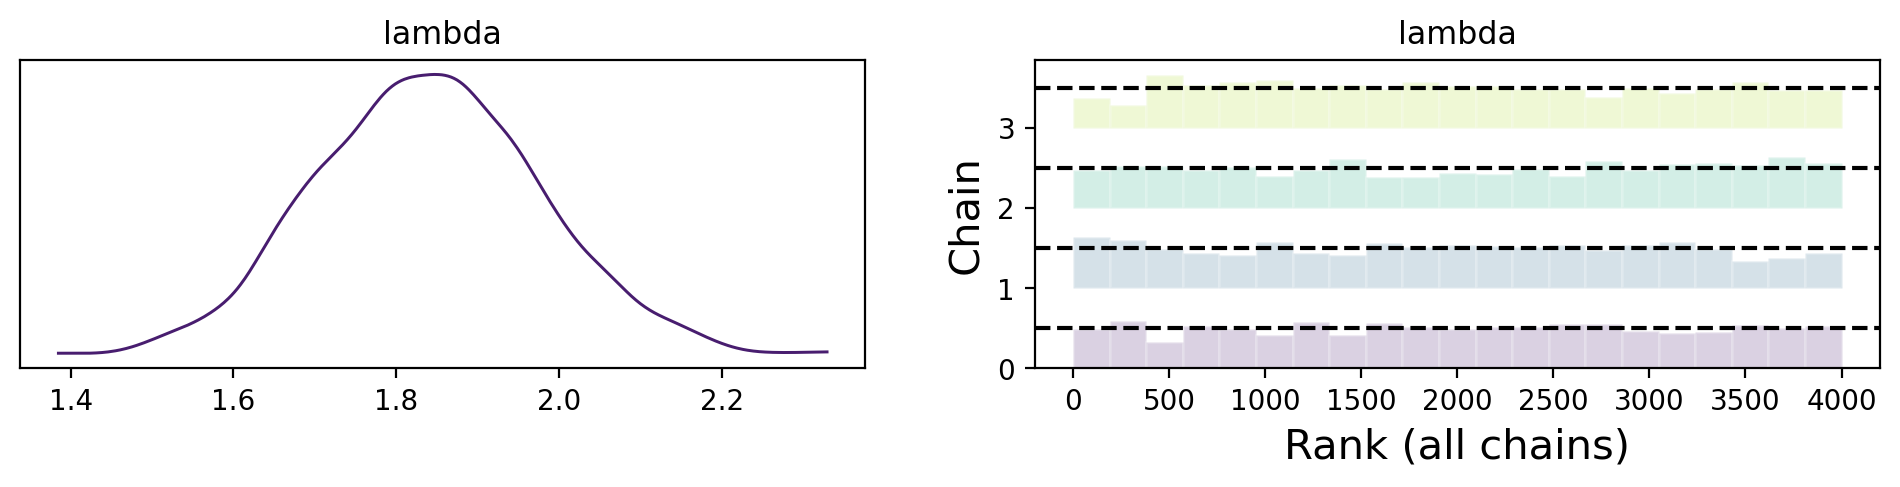

In [21]:
az.plot_trace(data=idata, combined=True, kind="rank_bars")
plt.show()

In [22]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,1.84,0.137,1.583,2.096,0.004,0.003,1488.0,2074.0,1.0


In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Sep 17 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

pymc      : 5.6.1
seaborn   : 0.12.2
numpy     : 1.25.2
matplotlib: 3.7.2
pandas    : 2.0.3
arviz     : 0.16.0
scipy     : 1.10.1

Watermark: 2.4.3

